In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

In [0]:
from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import Model
from keras.backend import reverse

In [0]:
max_words = 30000
max_words_length = 400
embedding_dimension = 300

lstm_options = {
    'units': 64,
    'dropout': 0.2,
    'return_sequences': True
}

convolution_options = {
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'valid',
    'activation': 'tanh',
    'dilation_rate': 1,
    'should_preactivate': True
}

In [0]:
def forward_lstm(comment_embedding):
    lstm = CuDNNLSTM(
        units=lstm_options['units'], 
        return_sequences=lstm_options['return_sequences']
    )(comment_embedding)
    lstm = Dropout(lstm_options['dropout'])(lstm)
    
    return lstm

def backward_lstm(comment_embedding):
    reversed_embeddings = Lambda(lambda x: reverse(x, axes=1))(comment_embedding)
    lstm = CuDNNLSTM(
        units=lstm_options['units'], 
        return_sequences=lstm_options['return_sequences']
    )(reversed_embeddings)   
    lstm = Dropout(lstm_options['dropout'])(lstm)

    return Lambda(lambda x: reverse(x, axes=1))(lstm)

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 128,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'dilation_rate': 1,
    'should_preactivate': True
})

scaled_residual_convolution_options=residual_convolution_options
scaled_residual_convolution_options['activation']='tanh'

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   dilation_rate=options['dilation_rate'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   dilation_rate=options['dilation_rate'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_add_block(input_layer, should_pool, dilation_rate=1):
    residual_convolution_options['dilation_rate'] = dilation_rate
    
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = add([residual_block, residual_block_pool])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate=0.2):
    model = Dense(256, activation='linear', kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(256, activation='linear', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    return Dense(6, activation='sigmoid', kernel_initializer='glorot_normal')(model)

In [15]:
input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('custom_fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

context = concatenate([
    forward_lstm(averaged_embedding_layer),
    averaged_embedding_layer,
    backward_lstm(averaged_embedding_layer)
])
context = Dropout(0.2)(context)

scaled_context = convolution_block(context, scaled_residual_convolution_options)

resnet = residual_add_block(scaled_context, should_pool = False, dilation_rate=1)
resnet = residual_add_block(resnet, should_pool = True, dilation_rate=1)
resnet = residual_add_block(resnet, should_pool = True, dilation_rate=1)
resnet = residual_add_block(resnet, should_pool = True, dilation_rate=1)

lstm_pooled_features = concatenate([
    yoon_kim_feature_extractor(scaled_context, convolution_options['filters']),
    GlobalMaxPooling1D()(scaled_context),
    GlobalAveragePooling1D()(scaled_context)
])

resnet_pooled_features = yoon_kim_feature_extractor(scaled_context, convolution_options['filters'])

pooled_features = concatenate([
    lstm_pooled_features,
    resnet_pooled_features
])

output_layer = classification_block(pooled_features, dropout_rate=0.2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [16]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 11:29 - loss: 0.1132 - acc: 0.9618

102112/102124 [============================>.] - ETA: 0s - loss: 0.0718 - acc: 0.9749

102124/102124 [==============================] - 912s 9ms/step - loss: 0.0718 - acc: 0.9749 - val_loss: 0.0644 - val_acc: 0.9753
Epoch 2/32
 10144/102124 [=>............................] - ETA: 12:36 - loss: 0.0541 - acc: 0.9806

102112/102124 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9802

102124/102124 [==============================] - 907s 9ms/step - loss: 0.0538 - acc: 0.9802 - val_loss: 0.0484 - val_acc: 0.9813
roc-auc: 0.9826 - roc-auc_val: 0.9795                                                                                                    
Epoch 3/32
  8672/102124 [=>............................] - ETA: 12:49 - loss: 0.0525 - acc: 0.9807

102112/102124 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9816

102124/102124 [==============================] - 907s 9ms/step - loss: 0.0495 - acc: 0.9816 - val_loss: 0.0481 - val_acc: 0.9810
Epoch 4/32
 10144/102124 [=>............................] - ETA: 12:37 - loss: 0.0489 - acc: 0.9817

102112/102124 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9821

102124/102124 [==============================] - 907s 9ms/step - loss: 0.0472 - acc: 0.9821 - val_loss: 0.0445 - val_acc: 0.9825
roc-auc: 0.9875 - roc-auc_val: 0.9842                                                                                                    
Epoch 5/32
  8672/102124 [=>............................] - ETA: 12:48 - loss: 0.0448 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9825

102124/102124 [==============================] - 906s 9ms/step - loss: 0.0457 - acc: 0.9825 - val_loss: 0.0510 - val_acc: 0.9792
Epoch 6/32
 10144/102124 [=>............................] - ETA: 12:37 - loss: 0.0432 - acc: 0.9832

102112/102124 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9829

102124/102124 [==============================] - 907s 9ms/step - loss: 0.0444 - acc: 0.9829 - val_loss: 0.0436 - val_acc: 0.9829
roc-auc: 0.9895 - roc-auc_val: 0.9863                                                                                                    
Epoch 7/32
  8672/102124 [=>............................] - ETA: 12:50 - loss: 0.0445 - acc: 0.9828

102112/102124 [============================>.] - ETA: 0s - loss: 0.0433 - acc: 0.9832

102124/102124 [==============================] - 908s 9ms/step - loss: 0.0433 - acc: 0.9832 - val_loss: 0.0420 - val_acc: 0.9833
Epoch 8/32
 10144/102124 [=>............................] - ETA: 12:36 - loss: 0.0423 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9836

102124/102124 [==============================] - 906s 9ms/step - loss: 0.0425 - acc: 0.9836 - val_loss: 0.0462 - val_acc: 0.9812
roc-auc: 0.9913 - roc-auc_val: 0.988                                                                                                    
Epoch 9/32
  8704/102124 [=>............................] - ETA: 12:49 - loss: 0.0411 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0418 - acc: 0.9837

102124/102124 [==============================] - 905s 9ms/step - loss: 0.0418 - acc: 0.9837 - val_loss: 0.0422 - val_acc: 0.9832

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00021763764380011708.
Epoch 10/32
  7968/102124 [=>............................] - ETA: 12:52 - loss: 0.0406 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9841

102124/102124 [==============================] - 903s 9ms/step - loss: 0.0407 - acc: 0.9841 - val_loss: 0.0406 - val_acc: 0.9839
roc-auc: 0.9921 - roc-auc_val: 0.988                                                                                                    
Epoch 11/32
  8672/102124 [=>............................] - ETA: 12:47 - loss: 0.0378 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0404 - acc: 0.9843

102124/102124 [==============================] - 903s 9ms/step - loss: 0.0403 - acc: 0.9843 - val_loss: 0.0419 - val_acc: 0.9831
Epoch 12/32
 10112/102124 [=>............................] - ETA: 12:34 - loss: 0.0414 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9845

102124/102124 [==============================] - 903s 9ms/step - loss: 0.0397 - acc: 0.9845 - val_loss: 0.0413 - val_acc: 0.9838
roc-auc: 0.9927 - roc-auc_val: 0.9881                                                                                                    
Epoch 13/32
  8672/102124 [=>............................] - ETA: 12:47 - loss: 0.0387 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9846

102124/102124 [==============================] - 907s 9ms/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0406 - val_acc: 0.9840
Epoch 14/32
 10112/102124 [=>............................] - ETA: 12:38 - loss: 0.0369 - acc: 0.9853

102112/102124 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9849

102124/102124 [==============================] - 907s 9ms/step - loss: 0.0384 - acc: 0.9849 - val_loss: 0.0417 - val_acc: 0.9834
roc-auc: 0.9933 - roc-auc_val: 0.9889                                                                                                    
Epoch 15/32
  8672/102124 [=>............................] - ETA: 12:50 - loss: 0.0373 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9849

102124/102124 [==============================] - 908s 9ms/step - loss: 0.0382 - acc: 0.9849 - val_loss: 0.0409 - val_acc: 0.9839
Epoch 16/32
 10112/102124 [=>............................] - ETA: 12:37 - loss: 0.0374 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9849

102124/102124 [==============================] - 909s 9ms/step - loss: 0.0381 - acc: 0.9849 - val_loss: 0.0409 - val_acc: 0.9841
roc-auc: 0.9937 - roc-auc_val: 0.989                                                                                                    
Epoch 17/32
  8672/102124 [=>............................] - ETA: 12:50 - loss: 0.0367 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9851

102124/102124 [==============================] - 907s 9ms/step - loss: 0.0373 - acc: 0.9851 - val_loss: 0.0410 - val_acc: 0.9842
Epoch 18/32
 10112/102124 [=>............................] - ETA: 12:37 - loss: 0.0382 - acc: 0.9848

102112/102124 [============================>.] - ETA: 0s - loss: 0.0369 - acc: 0.9853

102124/102124 [==============================] - 908s 9ms/step - loss: 0.0369 - acc: 0.9853 - val_loss: 0.0412 - val_acc: 0.9840
roc-auc: 0.9941 - roc-auc_val: 0.9891                                                                                                    
Epoch 19/32
  8672/102124 [=>............................] - ETA: 12:48 - loss: 0.0365 - acc: 0.9849

102112/102124 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9854

102124/102124 [==============================] - 907s 9ms/step - loss: 0.0366 - acc: 0.9854 - val_loss: 0.0406 - val_acc: 0.9839
Epoch 20/32
 10112/102124 [=>............................] - ETA: 12:38 - loss: 0.0350 - acc: 0.9864

102112/102124 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9856

102124/102124 [==============================] - 909s 9ms/step - loss: 0.0363 - acc: 0.9856 - val_loss: 0.0429 - val_acc: 0.9831

Epoch 00020: ReduceLROnPlateau reducing learning rate to 6.934809061931446e-05.
roc-auc: 0.9943 - roc-auc_val: 0.9889                                                                                                    
Epoch 21/32
  5920/102124 [>.............................] - ETA: 13:12 - loss: 0.0365 - acc: 0.9855

102112/102124 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9856

102124/102124 [==============================] - 907s 9ms/step - loss: 0.0360 - acc: 0.9856 - val_loss: 0.0407 - val_acc: 0.9842
Epoch 22/32
 10112/102124 [=>............................] - ETA: 12:40 - loss: 0.0351 - acc: 0.9863

102112/102124 [============================>.] - ETA: 0s - loss: 0.0357 - acc: 0.9856

102124/102124 [==============================] - 908s 9ms/step - loss: 0.0357 - acc: 0.9856 - val_loss: 0.0410 - val_acc: 0.9840
roc-auc: 0.9946 - roc-auc_val: 0.9889                                                                                                    
Epoch 23/32
  8672/102124 [=>............................] - ETA: 12:51 - loss: 0.0363 - acc: 0.9857

102112/102124 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9859

102124/102124 [==============================] - 908s 9ms/step - loss: 0.0358 - acc: 0.9859 - val_loss: 0.0414 - val_acc: 0.9838


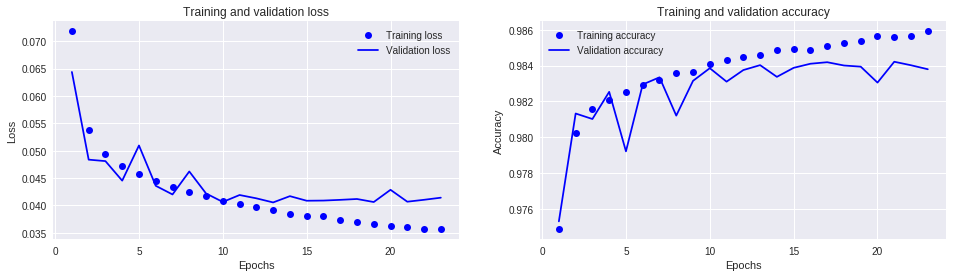

In [17]:
plot_history(history)

In [18]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 89s 3ms/step
([0.04003710075079188, 0.9842237046962805], 0.9908636987971603)
